### Importing Relevant Packages

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from pycaret.classification import * 
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

### Importing dataset

In [7]:
data = pd.read_csv('customer_churn.csv')

### Description of dataset

| Column Name          | Column Type  | Column Description                                          |
| -------------------- | ------------ | ------------------------------------------------------------ |
| State                | String       | The state where a customer comes from                        |
| Account length       | Integer      | Number of days a customer has been using services            |
| Area code            | Integer      | The area where a customer comes from                         |
| Phone number         | Alphanumeric | The phone number of a customer                               |
| International plan   | String       | The status of customer international plan                    |
| Voicemail plan       | String       | The status of customer voicemail plan                        |
| No. vmail msgs       | Integer      | Number of voicemail messages sent by a customer              |
| Total day minutes    | Float        | Total call minutes spent by a customer during the day time    |
| Total day calls      | Integer      | Total number of calls made by a customer during the day time |
| Total day charge     | Float        | Total amount charged to a customer during the day time       |
| Total eve minutes    | Float        | Total call minutes spent by a customer during the evening time |
| Total eve calls      | Integer      | Total number of calls made by a customer during the evening time |
| Total eve charge     | Float        | Total amount charged to a customer during the evening time   |
| Total night minutes  | Float        | Total call minutes spent by a customer during the night time |
| Total night calls    | Integer      | Total number of calls made by a customer during the night time |
| Total night charge   | Float        | Total amount charged to a customer during the night time     |
| Total intl minutes   | Float        | Total international call minutes spent by a customer         |
| Total intl calls     | Integer      | Total number of international calls made by a customer       |
| Total int charge     | Float        | Total international call amount charged to a customer        |
| Customer service calls | Integer    | Total number of customer service calls made by a customer    |
| Churn                | Boolean      | Whether a customer is churned or not                         |


## Exploratory Data Analysis

### Which states have the most number of customers?

In [9]:
customers = data.groupby('state')\
                .size()\
                .to_frame('n_custs')\
                .sort_values(by = 'n_custs', ascending = False)\
                .reset_index()
                

customers_flipped = data.groupby('state')\
                .size()\
                .to_frame('n_custs')\
                .sort_values(by = 'n_custs', ascending = True)\
                .reset_index()

top10 = customers[0:10]
bottom10 = customers_flipped[0:10]

x1 = top10['state']
x2 = bottom10['state']

y1 = top10['n_custs']
y2 = bottom10['n_custs']


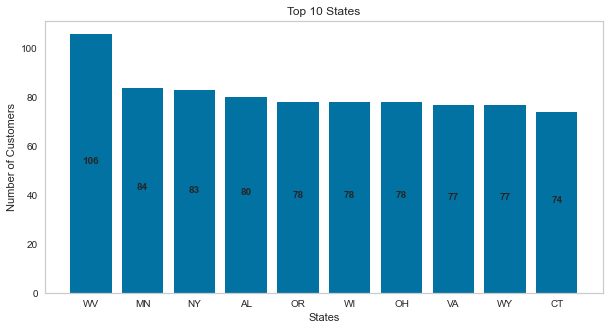

In [10]:
# Plotting top 10
plt.figure(figsize = (10,5))

plt.bar(x1, y1) # top 10

plt.title("Top 10 States")

# adding value labels
for i in range(len(x1)):
        plt.text(i, y1[i]//2, y1[i], ha = 'center', fontweight = 'bold')

plt.xlabel("States")
plt.ylabel("Number of Customers")

plt.grid(False)

plt.show()

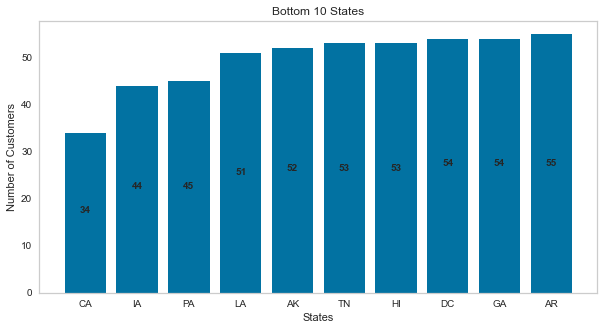

In [11]:
# Plotting top 10
plt.figure(figsize = (10,5))

plt.bar(x2, y2) # bottom 10

plt.title("Bottom 10 States")

# adding value labels
for j in range(len(x2)):
        plt.text(j, y2[j]//2, y2[j], ha = 'center', fontweight = 'bold')

plt.xlabel("States")
plt.ylabel("Number of Customers")

plt.grid(False)

plt.show()

As we can see from the above graphs, the state where most customers come from is West Virginia (WV) and the state where the least number of customers are from is California (CA). 

### Are there any correlations between the variables?

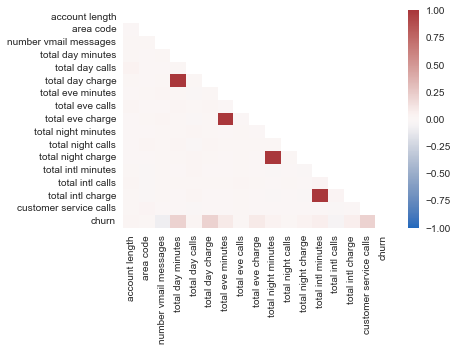

In [27]:
corr_matrix = data.corr().round(2)

# plotting half of the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix,vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)

plt.show()

From the correlation matrix above, 

There is positive correlation between:
- total day charge and total day minutes
- total eve charge and total eve minutes
- total intl charge and total intl minutes
- churn and customer service calls
- churn and total day charge
- churn and total day minutes


There is negative correlation between:
- churn and number of vmail messages


#### What is the distribution of churn in the dataset?

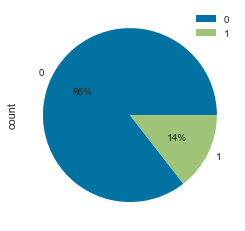

In [49]:
churn_dist = data.groupby('churn')\
            .size()\
            .to_frame('count')\
            .reset_index()\
            .plot(kind = 'pie', y = 'count', autopct = '%1.0f%%', legend = True)


From the dataset, we can see that the dataset contains 86% of those who did not churn and only 14% who churn. This is an issue as it may pose a problem to the accuracy of the predicted outcome. To combat this, we can use metrics such as F1 score and AUC to evaluate the different models.

## Data Preprocessing

In [147]:
# Converting Area Code to object type
data['area code'] = data['area code'].astype('object')

In [8]:
# Train Test split
churn = data.copy()
churn = churn.drop(columns = 'phone number') # phone number should not be needed to predict if a customer were to churn

y = churn['churn']
x = churn.drop(columns = ['churn'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 100)

## Model 1: Gradient Boosting Classifier

### Feature Encoding (One-Hot Encoding)

In [9]:
categorical_variables = []

for column in x_train.columns:
    if churn[column].dtype == 'object':
        categorical_variables.append(column)

print("Categorical variables: ", categorical_variables)

# One-hot encoding, fitted on the train dataset
enc_gbm = OneHotEncoder(sparse=False, handle_unknown="ignore")

transformer_gbm = ColumnTransformer([
    ("categorical", enc_gbm, categorical_variables)
], remainder="passthrough")

transformer_gbm.fit(x_train)

x_train_encoded_gbm = pd.DataFrame(transformer_gbm.transform(x_train), columns=transformer_gbm.get_feature_names())
x_test_encoded_gbm = pd.DataFrame(transformer_gbm.transform(x_test), columns=transformer_gbm.get_feature_names())

Categorical variables:  ['state', 'international plan', 'voice mail plan']


### Pipeline

In [72]:
gbm = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, max_depth = 5)

pipeline_gbm = Pipeline(steps=[("transformer", transformer_gbm), ("scaler", StandardScaler()), ('pca', PCA()), ("gbm", gbm)])

### Cross-Validation

In [73]:
def show_cv_results(pipeline):
    scores = cross_validate(pipeline, x_train, y_train, cv=10, return_train_score=True)
    print("Mean test score: ", scores["test_score"].mean())
    display(pd.DataFrame(scores))
    
show_cv_results(pipeline_gbm)

Mean test score:  0.8897116386471797


,fit_time,score_time,test_score,train_score
0,6.935135,0.010495,0.898876,0.994581
1,7.438788,0.006617,0.910112,0.991663
2,7.932485,0.005551,0.861423,0.995415
3,7.540681,0.007523,0.880150,0.990413
4,7.991297,0.042895,0.913858,0.991663
5,7.956623,0.008932,0.902622,0.995832
6,7.636662,0.049164,0.883459,0.992083
7,7.920136,0.005316,0.902256,0.992500
8,8.997865,0.006851,0.857143,0.988750
9,11.545357,0.020097,0.887218,0.988750


### Hyperparameter Tuning

In [ ]:
n_components = list(range(1, x.shape[1]+1, 3))

grid_gbm = {
    "gbm__max_depth": [1, 3, 5, 10],
    "gbm__learning_rate": [0.01, 0.1, 1],
    "gbm__n_estimators": [80, 100, 200, 300, 400],
    "pca__n_components": n_components
}

gs_gbm = GridSearchCV(pipeline_gbm, grid_gbm)
gs_gbm.fit(x_train, y_train)

In [88]:
# helper function to view grid search results

def report_GridSearchCV_results(gs):
    print("Best combination of hyperparams:\n", gs.best_params_, "\n")
    print("Best mean_test_score score:\n", gs.best_score_, "\n")
    
    scores = []
    for i in range(gs.n_splits_):
        scores.append(gs.cv_results_['split{}_test_score'.format(i)][gs.best_index_])
    print("Score by fold for best estimator:\n", scores, "\n")
    
    # View top 5 hyperparams combinations by mean_test_score (mean on "validation" set)
    print("Top 5 hyperparams combinations by mean_test_score:")
    display(pd.DataFrame(gs.cv_results_)[["rank_test_score", "mean_test_score"] 
                                            + ["param_" + param for param in gs.param_grid]]\
              .sort_values(by = "mean_test_score", ascending = False)\
              .set_index("rank_test_score").head(5))

In [100]:
report_GridSearchCV_results(gs_gbm)

Best combination of hyperparams:
 {'gbm__learning_rate': 0.1, 'gbm__max_depth': 5, 'gbm__n_estimators': 100, 'pca__n_components': 19} 

Best mean_test_score score:
 0.8994764986543556 

Score by fold for best estimator:
 [0.8951310861423221, 0.8874296435272045, 0.9136960600375235, 0.9080675422138836, 0.8930581613508443] 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_gbm__max_depth,param_gbm__learning_rate,param_gbm__n_estimators,param_pca__n_components
rank_test_score,,,,,
1,0.899476,5,0.1,100,19
2,0.896098,5,0.1,80,13
3,0.895352,5,0.1,80,19
4,0.893473,5,0.1,100,16
5,0.892726,5,0.1,400,13


### Performance on Test Set

              precision    recall  f1-score   support

       False       0.93      0.98      0.95       593
        True       0.67      0.38      0.48        74

    accuracy                           0.91       667
   macro avg       0.80      0.68      0.72       667
weighted avg       0.90      0.91      0.90       667



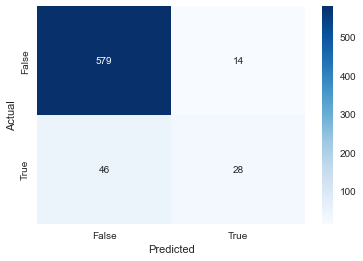

In [167]:
def score_model(model, x, y):
    pred = model.predict(x)
    print(classification_report(y, pred))
    
    cm = confusion_matrix(y, pred)
    columns = np.unique(y)
    df_cm = pd.DataFrame(cm, index=columns, columns=columns)
    ax = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    
score_model(gs_gbm, x_test, y_test)

### Fitting New Model

In [ ]:
gbm1 = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, max_depth = 5)

gbm1.fit(x_train_encoded_gbm, y_train)

## Model 2: Light Gradient Boosting Machine Classifier

### Feature Encoding (One-Hot Encoding)

In [14]:
# One-hot encoding, fitted on the train dataset
enc_lgbm = OneHotEncoder(sparse=False, handle_unknown="ignore")

transformer_lgbm = ColumnTransformer([
    ("categorical", enc_lgbm, categorical_variables)
], remainder="passthrough")

transformer_lgbm.fit(x_train)

x_train_encoded_lgbm = pd.DataFrame(transformer_lgbm.transform(x_train), columns=transformer_lgbm.get_feature_names())
x_test_encoded_lgbm = pd.DataFrame(transformer_lgbm.transform(x_test), columns=transformer_lgbm.get_feature_names())

### Pipeline

In [170]:
lgbm = LGBMClassifier(num_leaves = 30, max_depth = 5, learning_rate = 0.1, n_estimators = 100)

pipeline_lgbm = Pipeline(steps=[("transformer", transformer_lgbm), ("scaler", StandardScaler()), ('pca', PCA()), ("lgbm", lgbm)])

### Cross-Validation

In [102]:
show_cv_results(pipeline_lgbm)

Mean test score:  0.8889597589479317


,fit_time,score_time,test_score,train_score
0,0.493246,0.009582,0.883895,0.970404
1,0.226774,0.005909,0.910112,0.985827
2,0.197097,0.006725,0.868914,0.983743
3,0.409762,0.007826,0.880150,0.982493
4,0.277717,0.006020,0.906367,0.974990
5,0.246611,0.006200,0.917603,0.981242
6,0.224531,0.005388,0.883459,0.982917
7,0.204380,0.006571,0.875940,0.975833
8,0.212069,0.005920,0.879699,0.982500
9,0.245403,0.005267,0.883459,0.979583


### Hyperparameter Tuning

In [ ]:
# Hyperparameter tuning
grid_lgbm = {
    "lgbm__num_leaves": [20, 30, 40, 50],
    "lgbm__max_depth": [5, 15, 25, 35],
    "lgbm__n_estimators": [80, 100, 200, 300, 400], 
    "pca__n_components": n_components
}

gs_lgbm = GridSearchCV(pipeline_lgbm, grid_lgbm)
gs_lgbm.fit(x_train, y_train)

In [104]:
report_GridSearchCV_results(gs_lgbm)

Best combination of hyperparams:
 {'lgbm__max_depth': 35, 'lgbm__n_estimators': 200, 'lgbm__num_leaves': 40, 'pca__n_components': 16} 

Best mean_test_score score:
 0.9039729887359375 

Score by fold for best estimator:
 [0.9119850187265918, 0.8949343339587242, 0.9155722326454033, 0.9118198874296435, 0.8855534709193246] 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_lgbm__num_leaves,param_lgbm__max_depth,param_lgbm__n_estimators,param_pca__n_components
rank_test_score,,,,,
1,0.903973,40,35,200,16
2,0.902473,40,35,400,19
3,0.902095,30,35,100,19
4,0.899850,50,15,200,13
5,0.899474,30,15,100,7


### Performance on Test Set

              precision    recall  f1-score   support

       False       0.93      0.97      0.95       593
        True       0.67      0.43      0.52        74

    accuracy                           0.91       667
   macro avg       0.80      0.70      0.74       667
weighted avg       0.90      0.91      0.90       667



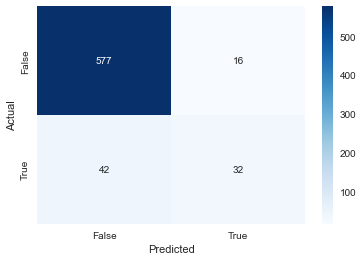

In [172]:
score_model(gs_lgbm, x_test, y_test)

### Fitting new model

In [15]:
lgbm1 = LGBMClassifier(max_depth = 35, n_estimators = 200, learning_rate = 0.1, num_leaves = 40)

lgbm1.fit(x_train_encoded_lgbm, y_train)

LGBMClassifier(max_depth=35, n_estimators=200, num_leaves=40)

## Model 3: Logistic Regression

### Feature Encoding (One-Hot Encoding)

In [16]:
enc_lr = OneHotEncoder(sparse=False, handle_unknown="ignore")

transformer_lr = ColumnTransformer([
    ("categorical", enc_lr, categorical_variables)
], remainder="passthrough")

transformer_lr.fit(x_train)

x_train_encoded_lr = pd.DataFrame(transformer_lr.transform(x_train), columns=transformer_lr.get_feature_names())
x_test_encoded_lr = pd.DataFrame(transformer_lr.transform(x_test), columns=transformer_lr.get_feature_names())

### Pipeline

In [140]:
lr = LogisticRegression(max_iter=1000, solver="liblinear", penalty="l1")

pipeline_lr = Pipeline(steps=[("transformer", transformer_lr), ("scaler", StandardScaler()), ('pca', PCA()), ("logistic", lr)])

### Cross-Validation

In [141]:
show_cv_results(pipeline_lr)

Mean test score:  0.8540846498268142


,fit_time,score_time,test_score,train_score
0,0.097618,0.008639,0.876404,0.864527
1,0.048250,0.005756,0.857678,0.868278
2,0.044411,0.006606,0.861423,0.866194
3,0.043004,0.005353,0.835206,0.868278
4,0.046956,0.006065,0.850187,0.864110
5,0.042130,0.005618,0.853933,0.865777
6,0.047996,0.004886,0.849624,0.868750
7,0.045980,0.005080,0.834586,0.868750
8,0.043011,0.006140,0.845865,0.865833
9,0.045215,0.006739,0.875940,0.866667


### Hyperparameter Tuning

In [ ]:
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']

grid_lr = {
    "logistic__C": C, 
    "logistic__penalty": penalty,
    "pca__n_components": n_components
}

gs_lr = GridSearchCV(pipeline_lr, grid_lr)
gs_lr.fit(x_train, y_train)

In [143]:
report_GridSearchCV_results(gs_lr)

Best combination of hyperparams:
 {'logistic__C': 2222.996482526191, 'logistic__penalty': 'l2', 'pca__n_components': 19} 

Best mean_test_score score:
 0.864590228443339 

Score by fold for best estimator:
 [0.8670411985018727, 0.8667917448405253, 0.8611632270168855, 0.8611632270168855, 0.8667917448405253] 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_logistic__C,param_logistic__penalty,param_pca__n_components
rank_test_score,,,,
1,0.864590,2222.996483,l2,19
2,0.864590,6866.48845,l1,13
3,0.864215,0.828643,l2,16
4,0.864211,232.995181,l1,16
5,0.863841,0.126486,l2,19


### Performance on Test Set

              precision    recall  f1-score   support

       False       0.91      0.97      0.94       593
        True       0.42      0.19      0.26        74

    accuracy                           0.88       667
   macro avg       0.66      0.58      0.60       667
weighted avg       0.85      0.88      0.86       667



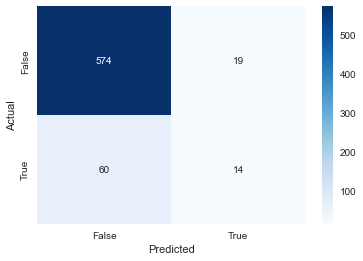

In [173]:
score_model(gs_lr, x_test, y_test)

### Fitting New Model

In [ ]:
lr1 = LogisticRegression(max_iter=1000, solver="liblinear", penalty="l2", C = 2223)

lr1.fit(x_train_encoded_lr, y_train)

## Model Evaluation

In [18]:
def get_results(model, X, y):
    y_pred = model.predict(X)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred)

    return [round(f1, 2), round(auc, 2)]

In [22]:
model_eval = []

model_eval.append({'model': 'Gradient Boosting',
                    'f1_score': get_results(gbm1, x_test_encoded_gbm, y_test)[0],
                    'AUC': get_results(gbm1, x_test_encoded_gbm, y_test)[1]})

model_eval.append({'model': 'Light Gradient Boosting',
                    'f1_score': get_results(lgbm1, x_test_encoded_lgbm, y_test)[0],
                    'AUC': get_results(lgbm1, x_test_encoded_lgbm, y_test)[1]})

model_eval.append({'model': 'Logistic Regression',
                    'f1_score': get_results(lr1, x_test_encoded_lr, y_test)[0],
                    'AUC': get_results(lr1, x_test_encoded_lr, y_test)[1]})

In [27]:
model_eval = pd.DataFrame(model_eval)

model_eval.sort_values(by = ['f1_score', 'AUC'], ascending = [False, False]).reset_index(drop = True)

,model,f1_score,AUC
0,Light Gradient Boosting,0.89,0.93
1,Gradient Boosting,0.86,0.92
2,Logistic Regression,0.34,0.62


From the model evaluation, we can see that the Light Gradient Boosting has the highest f1_score and AUC among the 3 models. Thus, it should be the model to be used to predict if the customer churns or not. We can also see that in all 3 models, they do extremely well in predicting if a customer does not churn as all 3 models have the higher f1_score when predicting the False case.